# NLP Classification Project - ESG Analysis

## Α. Dataset Preparation & Preprocessing

### Α1. Data Import & Cleaning

In [1]:
# Ignore user warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

- Importing article files from subfolders by industry

In this cell we load all ESG articles from subfolders (by industry - e.g. Oil & Gas, Biotech, etc.). We create a dataframe containing the unique ID of the article, the path to the file, and the corresponding industry.

In [ ]:
import os
import pandas as pd

# Create a mapping to match each folder (branch) with a prefix
# e.g. OIL & GAS → OG
sector_map = {
    "OIL & GAS": "OG",
    "FOOD SECTOR": "FS",
    "BIOTECH & PHARMA": "BP",
    "CHEMICALS & PLASTIC": "CP"
}

# Base folder containing all subfolders with articles (.txt files)
base_dir = ".\\Final Data"

# List where the details of each article will be stored
rows = []

# Iterates through all sector folders
# For each folder (i.e. sector) in sector_map:
# 1. build the full path for the folder, 
# 2. goe through all files in the folder, 
# 3. process only .txt files
for folder, prefix in sector_map.items():
    folder_path = os.path.join(base_dir, folder)  
    for fname in os.listdir(folder_path):
        if fname.endswith(".txt"): # only hold .txt files
            fpath = os.path.join(folder_path, fname) # full file's path
            basename = fname.replace(".txt","")   # remove ".txt" from the name (e.g. 1001s.txt -> 1001s)
            file_id = f"{prefix}_{basename[:-1]}" # remove the last letter (e/s/g) for uniform ID (e.g. 1001s -> 1001)
            rows.append({
                "id": file_id, # file's unique ID
                "path": fpath, # file's full path
                "sector": prefix # sector prefix
            })

# Create a dataframe with the file paths
df_files = pd.DataFrame(rows)
# Display how many files were read in total
print("Total articles in folder:", len(df_files))
print(df_files)

Total articles in folder: 2861
           id                                               path sector
0     OG_1000  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     OG
1     OG_1009  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     OG
2     OG_1018  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     OG
3     OG_1022  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     OG
4     OG_1023  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     OG
...       ...                                                ...    ...
2856   CP_992  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     CP
2857   CP_993  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     CP
2858   CP_995  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     CP
2859   CP_996  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     CP
2860     CP_9  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...     CP

[2861 rows x 3 columns]


- Import E/S/G labels from excel file

In this step, we load the labels of the articles that have been labeled based on the ESG categories from an Excel file named `articles_labeling.xlsx`. The file includes for each article which of the E (Environmental), S (Social), or G (Governance) categories apply.

In [3]:
# Import excel with E/S/G labels
df_labels = pd.read_excel("articles_labeling.xlsx")
print("Articles from excel:", len(df_labels))

Articles from excel: 2861


- Compatibility Check: Matching IDs between articles and labels

Before merging the data, we check that all IDs in the labeling file (`df_labels`) are also present in the text files (`df_files`). This ensures that we do not have inconsistencies that would cause errors in training the model

In [4]:
missing_ids = set(df_labels["filename"]) - set(df_files["id"])

if missing_ids:
    print("The following IDs from Excel were not found in the article folders:")
    print(missing_ids)
else:
    print("All the IDs from excel are in the article folders.")

All the IDs from excel are in the article folders.


- Exploring the distribution of tags (E/S/G)

In [5]:
# We check how many articles are tagged with each ESG category. 
# We calculate both the absolute number and the percentage of each tag appearing in the dataset.


# Calculate the number of articles belonging to each ESG category
# Since the columns have values ​​1/0, sum returns how many times each label exists
label_counts = df_labels[['E', 'S', 'G']].sum()
print("Count of articles per label:\n", label_counts)


# Calculate the percentage of articles that have each label (multiplied by 100 for percentage)
# That is how many articles have E, how many S, how many G, as a percentage of the total
label_percent = df_labels[['E', 'S', 'G']].mean() * 100
print("\nPercentage of articles per label:\n", label_percent)

Count of articles per label:
 E     46
S    120
G     37
dtype: int64

Percentage of articles per label:
 E    1.607829
S    4.194338
G    1.293254
dtype: float64


- Merge articles with ESG tags

We merge the dataframe containing the file paths (`df_files`) with the dataframe of the tags (`df_labels`). 
This creates a single dataframe containing:
- the `id` of the article
- the `E`, `S`, `G` tags
- the `path` to the corresponding .txt file

The `path` column is necessary for loading the text in a later step.

In [6]:
# Rename the column "filename" to "id" to be compatible with the IDs from the .txt files
# Merge the two dataframes based on the common field "id"

df_labels = df_labels.rename(columns={"filename": "id"})
df_labels = df_labels.merge(df_files, on="id", how="inner")
print(df_labels)

           id  E  S  G                                               path  \
0     BP_1001  0  0  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
1     BP_1002  0  0  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
2     BP_1005  0  0  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
3     BP_1006  0  0  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
4     BP_1008  0  0  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
...       ... .. .. ..                                                ...   
2856  FS_1610  0  1  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
2857  FS_1670  0  1  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
2858    FS_15  0  1  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
2859  OG_3336  0  1  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   
2860  OG_1000  0  1  0  C:\Users\xrhst\OneDrive\Υπολογιστής\master\Mac...   

     sector  
0        BP  
1        BP  
2        BP  
3        BP  
4    

- Text Cleanup Function

We define a helper function `clean_text()` that applies preprocessing to each article, in order to convert it into a "cleaner" form suitable for use in NLP models.
The function includes:
1. Conversion to lowercase,
2. Removal of URLs, numbers and non-Latin characters,
3. Preservation of basic punctuation marks (.,-%$£€),
4. Normalization of characters with accents or special symbols.

In [7]:
import re, unicodedata
from unidecode import unidecode

# Text cleaning function
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return "" # if not a string (e.g. NaN), return empty string
    s = unicodedata.normalize("NFKC", s) # unicode normalization (e.g. changing characters to a compatible format)
    s = unidecode(s) # remove accents (e.g. á → a, ü → u)
    s = s.lower() # convert to lowercase
    s = re.sub(r"https?://\S+|www\.\S+", " ", s) # remove URLs (e.g. http://..., www....)
    s = re.sub(r"[^a-z\s]", " ", s) # keep only latin characters and spaces
    s = re.sub(r"\d+", " ", s) # subtract numbers
    s = re.sub(r"\s+", " ", s).strip() # removing unnecessary spaces
    return s

- Load & Clean Corpus

This cell reads the articles from the `.txt` files and creates the final corpus for the classification model. Specifically:

1. **Copies** the `dataframe` containing paths and E/S/G labels.
2. **Reads the content** of each file and stores it in a new `text_raw` column.
3. Applies **pre-text cleaning** with the `clean_text()` function and creates a `text` column.
4. Converts columns `E`, `S`, `G` to integer values ​​(`int`), so that they are suitable for classification.
5. Finally, returns the cleaned dataframe and the corresponding labels.

The result is a clean dataset ready for classifier training (multi-label classification).

In [8]:
def load_corpus(df_labels: pd.DataFrame):
    df = df_labels.copy() # create a copy of the DataFrame containing paths and labels

# Read the raw text from each article and create two columns:
# 1. "text_raw": the text as it exists in the file
# 2. "text": the text cleaned with the clean_text() function
    texts = []
    for p in df["path"]:
        with open(p, "r", encoding="utf-8", errors="ignore") as f:
            texts.append(f.read()) # Save the content of the article
    df["text_raw"] = texts # column with the original text

    #Apply the function created above "clean_text" to do the data cleaning on the texts
    df["text"] = df["text_raw"].apply(clean_text) # plain text column

    # verify that E/S/G labels are integers
    label_cols = ["E","S","G"]
    for c in label_cols:
        df[c] = df[c].astype(int)

    return df, label_cols

# Call the function "Corpus" to load the final dataframe
df, label_cols = load_corpus(df_labels)

- Overview of Original and Clean Article Text

In this cell we select a specific article (with `index = i`) and print:
1. The original text as it exists in the file (`text_raw`)
2. The cleaned text as it results after applying `clean_text()` (without URLs, numbers, capitalization, etc.)

This is useful to confirm that the cleaning has been done correctly and no important information was lost.

In [9]:
i = 0  # any number that corresponds to an article

# Display the raw (unprocessed) text from the .txt file
print("Raw text:")
print(df["text_raw"].iloc[i])

# Display the cleaned text (from clean_text)
print("\nCleaned text:")
print(df["text"].iloc[i])

Raw text:
Wire: Bloomberg Law Regulatory & Tax Summaries (BNA)
Date: Nov 29 2019  14:29:14
Regulatory Review Period/Ozempic

 
      (Bloomberg Law) -- Notice of the FDA announces the
determination of the regulatory review period for the human drug
product Ozempic (semaglutide), in response to patent term
extension application from Novo Nordisk A/S. The drug product is
indicated for glycemic control in adults with type 2 diabetes
mellitus. Comments and requests for redeterminations are due Jan.
28, 2020. Petitions for a determination of whether the applicant
for extension acted with due diligence during the regulatory
review period are due May 27, 2020. Contact: Beverly Friedman;
FDA, Office of Regulatory Policy; 301-796-3600
     84 FR 65826 (11/29/2019)

To view the complete story, {BBLS DD PKA0R2C3A1F0<GO>}
Run {BNA<go>} to subscribe to Bloomberg Law Reports.
 
-0- Nov/29/2019 12:29 GMT

-----------------------------====================------------------------------
                

**Cleaned Article Evaluation Conclusion (see example above)**

The `cleaned version` retains useful keywords, such as:
**regulatory, fda, ​​review, drug product, ozempic, novo nordisk, diligence, policy**

These are important for word-based models (e.g. TF-IDF, SHAP, LIME), as:
1. The words **"regulatory"** and **"fda"** enhance a possible categorization into **Governance (G)**.
2. The words **"drug product", "ozempic", "type 2 diabetes"** are associated with **Social (S)**, as they relate to public health issues.

Furthermore, the cleaned version retains sufficient information for qualitative embeddings via **NSS / Sentence Transformers** or for sparse representations such as **TF-IDF** which will be tested below.
This confirms that the `corpus` function and the cleaning pipeline preserve the critical tokens for ESG analysis, enhancing the ability to interpret and classify.

------------------------------------------------------------------------------------------------------------------------------------------------------------

### A2. Exploratory Data Analysis (EDA)

At this stage we analyze the dataset to better understand the structure, labels and content of the articles. This includes:

- Article length analysis
- Most frequent words (without stopwords)
- Distribution of articles by sector
- Frequency of ESG labels and their combinations (multi-label)

##### A2.1 Article Length Statistics

In [10]:
# Compute article length in words
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
 
# Statistics (mean, min, max, median)
average_length = df['word_count'].mean()
min_length = df['word_count'].min()
max_length = df['word_count'].max()
median_length = df['word_count'].median()
 
# Results
print(f"Average article length: {average_length:.2f} words")
print(f"Min length: {min_length} words")
print(f"Max length: {max_length} words")
print(f"Median length: {median_length} words")

Average article length: 1183.74 words
Min length: 0 words
Max length: 51816 words
Median length: 512.0 words


##### A2.2 Most Common `Pure` Words

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

# Definition of stopwords (useless words)
stop_words = set(stopwords.words('english'))

# Collection of all words except stopwords
all_words_clean = [word for text in df['text'] for word in text.split() if word.lower() not in stop_words]

# Calculate frequencies and display 20 most frequent
word_counts = Counter(all_words_clean)
most_common_clean = word_counts.most_common(20)
print(most_common_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xrhst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('company', 11501), ('said', 8770), ('also', 7647), ('ni', 7505), ('business', 7399), ('new', 6943), ('year', 6769), ('us', 5976), ('may', 5679), ('first', 5537), ('million', 5500), ('story', 5385), ('one', 5366), ('energy', 5085), ('end', 5011), ('oil', 4937), ('go', 4772), ('services', 4764), ('u', 4682), ('bloomberg', 4535)]


##### Α2.3 Distribution of Articles by Sector

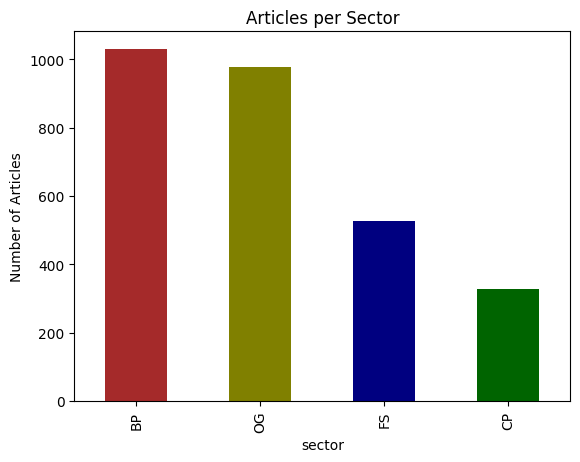

In [12]:
import matplotlib.pyplot as plt

# Bar chart with sector for each article
df['sector'].value_counts().plot(kind='bar', color=['brown','olive','navy','darkgreen'])
plt.ylabel('Number of Articles')
plt.title('Articles per Sector')
plt.show()

##### Α2.4 ESG Labels and Combinations

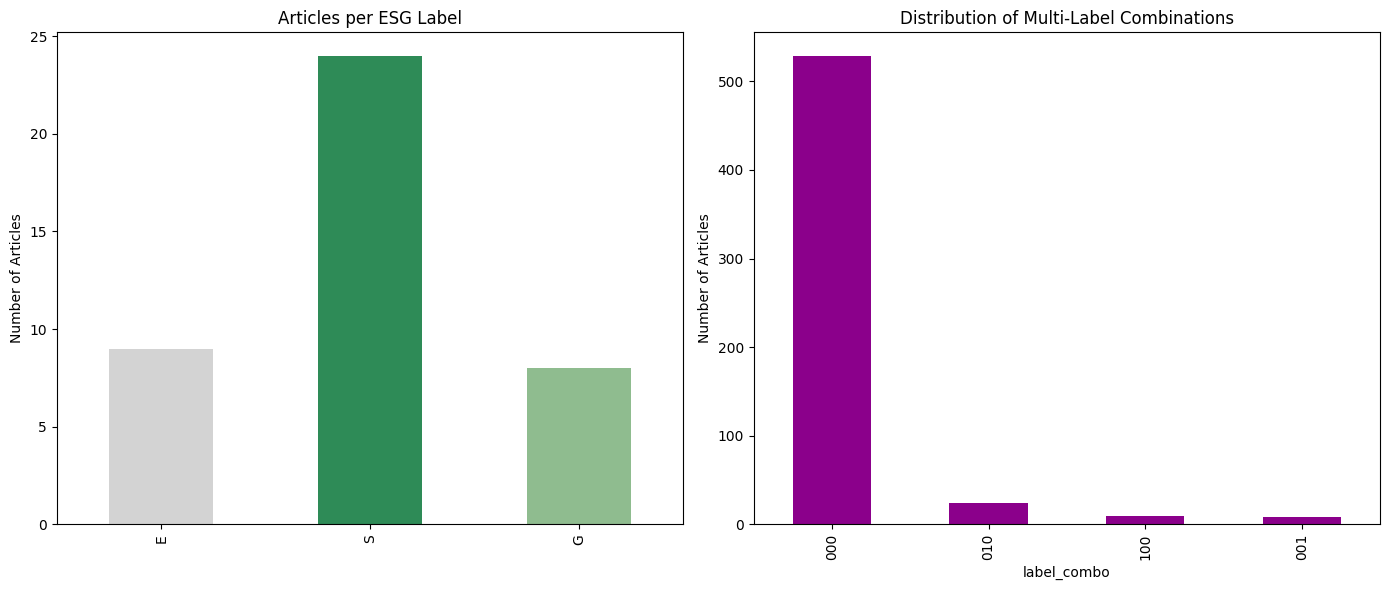

In [85]:
# Individual label counts
label_counts = df[['E','S','G']].sum()
 
# Multi-label combinations
df['label_combo'] = df['E'].astype(str) + df['S'].astype(str) + df['G'].astype(str)
combo_counts = df['label_combo'].value_counts()
 
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6))  # 1 row, 2 columns
 
# Plot 1: ESG label counts
label_counts.plot(kind='bar', color=['lightgrey','seagreen','darkseagreen'], ax=axes[0])
axes[0].set_ylabel('Number of Articles')
axes[0].set_title('Articles per ESG Label')
 
# Plot 2: Multi-label combinations
combo_counts.plot(kind='bar', color='darkmagenta', ax=axes[1])
axes[1].set_ylabel('Number of Articles')
axes[1].set_title('Distribution of Multi-Label Combinations')
 
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------

### A3. Train / Test Split (Stratified Multi-label)


In this step, we split the dataset into train and test sets in a ratio of 80-20. 
In multi-label problems like ESG it is important that the training and test sets maintain a similar distribution of label combinations. This is achieved through the `stratified_multilabel_split()` function, which converts the labels (E, S, G) to strings like "100", "011" and uses `train_test_split` with `stratify` option to ensure that the subsets maintain the complexity of the labeling.

**Advantages:**
- The balance between simple and complex labeling is maintained.
- The generalization of the model during training and evaluation is improved.

In [14]:
!pip install seaborn
from sklearn.model_selection import train_test_split
import seaborn as sns

# Function for Stratified Train/Test Split in a Multi-label Setting
def stratified_multilabel_split(df, label_cols, test_size=0.2, random_state=42):
    # convert labels (e.g. [1,0,0]) to string patterns like "100"
    y_pattern = df[label_cols].astype(str).agg("".join, axis=1)

    # perform stratified split based on label patterns to preserve the proportions of label combinations
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=y_pattern
    )

    # Print statistics before/after split
    print("\nLabel Distribution BEFORE Split:")
    print(df[label_cols].sum())
    
    print("\nLabel Distribution in TRAIN Set:")
    print(train_df[label_cols].sum())
    
    print("\nLabel Distribution in TEST Set:")
    print(test_df[label_cols].sum())

    # Visualization
    df["label_combo"] = df[label_cols].astype(str).agg("".join, axis=1)
    train_df["label_combo"] = train_df[label_cols].astype(str).agg("".join, axis=1)
    test_df["label_combo"] = test_df[label_cols].astype(str).agg("".join, axis=1)

    combo_df = pd.DataFrame({
        "Full": df["label_combo"].value_counts(normalize=True),
        "Train": train_df["label_combo"].value_counts(normalize=True),
        "Test": test_df["label_combo"].value_counts(normalize=True)
    }).fillna(0)

    # Barplot
    combo_df.plot(kind="bar", figsize=(12,6), color=['saddlebrown','peru','bisque'])
    plt.title("Distribution of Label Combinations Before/After Split")
    plt.ylabel("Proportion")
    plt.xlabel("Label Combination (E/S/G)")
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

    return train_df, test_df


Label Distribution BEFORE Split:
E     46
S    120
G     37
dtype: int64

Label Distribution in TRAIN Set:
E    37
S    96
G    29
dtype: int64

Label Distribution in TEST Set:
E     9
S    24
G     8
dtype: int64


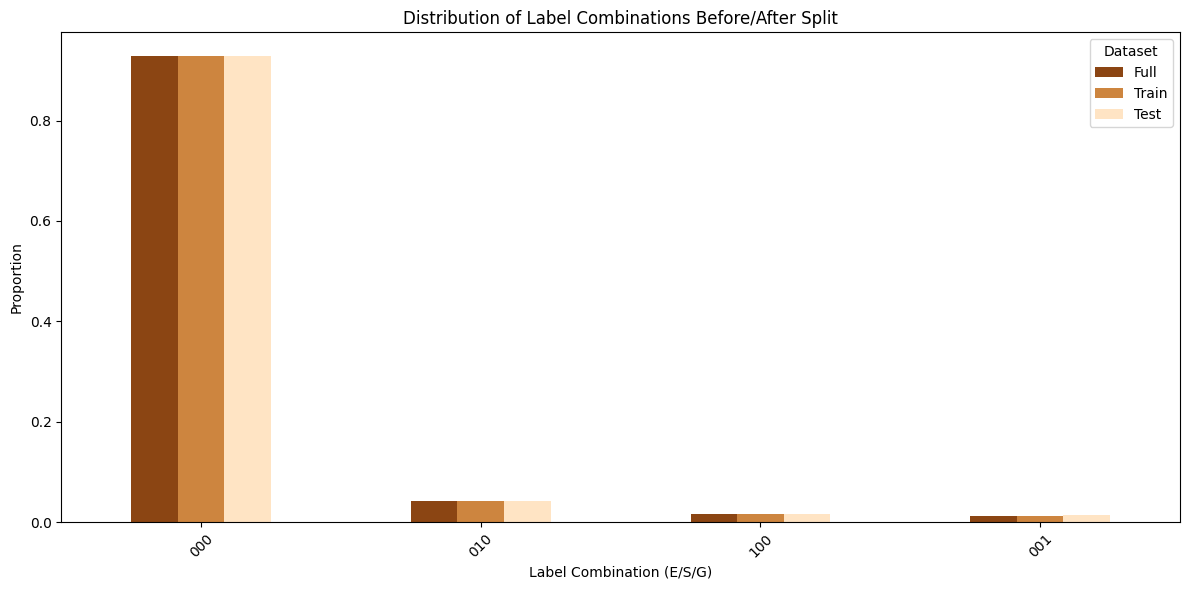

Train size: 2288
Test size: 573


In [15]:
# Call function
train_df, test_df = stratified_multilabel_split(df, label_cols)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

In [16]:
# Copy the already cleaned text to a new column 'text_clean' to apply further preprocessing without messing up the original 'text'
train_df["text_clean"] = train_df["text"]
test_df["text_clean"] = test_df["text"]

After text cleaning, some articles may be empty. In this step we count how many articles have empty content (`text_clean` with length 0) in the train and test set respectively and then we deleted them.

In [17]:
# Count empty articles after cleaning
for name, df in [("Train", train_df), ("Test", test_df)]:
    empty_count = (df["text_clean"].str.len() == 0).sum()
    print(f"{name} set - Empty articles after cleaning: {empty_count}")

Train set - Empty articles after cleaning: 14
Test set - Empty articles after cleaning: 3


In [18]:
# Delete empty articles after cleaning
train_df = train_df[train_df["text_clean"].str.strip() != ""].reset_index(drop=True)
test_df = test_df[test_df["text_clean"].str.strip() != ""].reset_index(drop=True)

print("Train set after dropping empty:", len(train_df))
print("Test set after dropping empty:", len(test_df))

Train set after dropping empty: 2274
Test set after dropping empty: 570


------------------------------------------------------------------------------------------------------------------------------------------------------------

## B. Feature Engineering

### B1. Text Representation (TF-IDF)

##### B1.1. Baseline Μοντέλο: TF-IDF (stopwords removal in vectorizer) + Logistic Regression (Multi-Label)

We start with a simple baseline scenario using:
- **TF-IDF vectorization** to convert text to numeric features ((5000 unigram features, english stopwords)).
- **Multi-label Logistic Regression** to classify into labels E, S, G with balanced class weights.

The goal is to have a benchmark for the performance of a simple linear model, before moving on to more complex representations (e.g. embeddings, transformers).

The evaluation is done with precision, recall, f1-score per category (E, S, G).

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

# max_features = 5000 → limit to keep the most important tokens
# ngram_range = (1,1) → Use of monograms only
# remove english stopwords in TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words="english")

# Apply to the training set and transform the test set
X_train = vectorizer.fit_transform(train_df["text"])
X_test  = vectorizer.transform(test_df["text"])

# Labels (E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score

# Classifier (Logistic Regression for multi-label)
# 'liblinear' -> ideal for small/middle datasets, 
# 'balanced" -> unbalanced labels,
# 'random_state' sets the seed for randomness and ensures that the results are reproducible (the same every time).
base_clf = LogisticRegression(solver='liblinear', max_iter=1000, class_weight="balanced", random_state=42) 

# MultiOutputClassifier allows separate Logistic for each label (E, S, G)
clf = MultiOutputClassifier(base_clf)

# Train model
clf.fit(X_train, y_train)

# Evaluation & Report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))

              precision    recall  f1-score   support

           E       0.58      0.78      0.67         9
           S       0.24      0.54      0.33        24
           G       0.35      0.88      0.50         8

   micro avg       0.31      0.66      0.42        41
   macro avg       0.39      0.73      0.50        41
weighted avg       0.33      0.66      0.44        41
 samples avg       0.05      0.05      0.05        41



*Results Commentary*

- E (Environmental): `F1` = 0.67 -> the best performance with a good balance of precision (0.58) and recall (0.78).
- S (Social): `F1` = 0.33 -> the worst performance, low `Precision`= 0.24, `Recall`= 0.54 shows that many true positives are detected but with many false positives.
- G (Governance): High `Recall`= 0.88, low `Precision`= 0.35, meaning that the model often predicts G, but with low accuracy.

*Overall:*
- `Macro F1` = 0.50-> medium performance, especially considering the imbalance in labels. 
- `Micro F1` = 0.42 -> quite low for practical use. 

*Conclusion:*

More complex representations (n-grams, embeddings, transformers) are needed for improvement.

*Next Steps*: **Lemmatization**

##### B1.2 TF-IDF (stopwords removal in vectorizer) + Lemmatization

In this step we use the `spaCy` library to apply *lemmatization* to our texts. Lemmatization converts words to their basic/"normal" form (e.g. *running* -> *run*, *companies* -> *company*). This reduces the vocabulary and makes the TF-IDF representation cleaner and more consistent.

Additionally, we load the English NLP model of spaCy, which is a library for NLP natural language processing that offers different capabilities. In our case we are only interested in lemmatization to normalize the words, so we disable `parser` - we do not need syntactic analysis - and `NER` - nor entity recognition.

Thus, the model loads lighter and runs faster.

In [198]:
import spacy

# Load spaCy (only for tokenization + lemmatization)
# Disable parser/NER for speed (they are not needed here)
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","tok2vec"])

def lemmatize_texts(texts, batch_size=100):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        clean_texts.append(" ".join([token.lemma_ for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set - new column
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# TF-IDF vectorization on lemmatized texts (unigrams + stopwords removal)
# same features (max_features=5000, ngram_range=(1,1), stop_words="english" removal)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words="english")
X_train = vectorizer.fit_transform(train_df["text_lemma"])
X_test  = vectorizer.transform(test_df["text_lemma"])

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Logistic Regression Classifier
# same features (solver="liblinear", class_weight="balanced", random_state=42)
base_clf = LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42)
clf = MultiOutputClassifier(base_clf)

# Train model
clf.fit(X_train, y_train)

# Evaluation & Report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))

              precision    recall  f1-score   support

           E       0.58      0.78      0.67         9
           S       0.24      0.54      0.33        24
           G       0.35      0.88      0.50         8

   micro avg       0.31      0.66      0.42        41
   macro avg       0.39      0.73      0.50        41
weighted avg       0.33      0.66      0.44        41
 samples avg       0.05      0.05      0.05        41



*Results Commentary*

- E (Environmental): `F1` = 0.67 -> consistently the best category, good balance `Precision` = 0.58 and `Recall`= 0.78.
- S (Social): `F1` = 0.33 -> still the most difficult category, low `Precision` = 0.24, moderate `Recall` = 0.54.
- G (Governance): `F1` = 0.50 -> slight improvement over previous steps, moderate `Precision` = 0.35, high `Recall`= 0.88

*Overall:*
- Macro `F1` = 0.50 -> improvement over baseline where it was 0.50. 
- Micro `F1` = 0.42 -> similar to baseline ~ 0.42. 
- Weighted `F1` = 0.44 -> small overall improvement (baseline ~ 0.44).

*Conclusion:* 

The combination **lemmatization + stopwords removal** did not bring a significant improvement in the overall result because TF-IDF with unigrams and Logistic Regression only sees individual words and misses the meaning of phrases/contexts and cannot learn more complex relationships.

*Next Steps*:
**N-grams**

##### B1.3 TF-IDF (stopwords removal in vectorizer) + Lemmatization + N-grams

B1.3.1 Unigrams (1,1) + Bigrams (1,2)

**Bigrams** are sequences of two consecutive words (e.g. *"climate change"*, *"carbon emissions"*). Unlike **unigrams**, which look at each word individually, bigrams capture small pieces of context and allow the model to distinguish phrases that have special meaning. With TF-IDF, in addition to individual words, features corresponding to two-word phrases are also created, thus increasing the vocabulary and the model's ability to detect patterns.

In [199]:
# TF-IDF with unigrams + bigrams

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def lemmatize_texts(texts):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        clean_texts.append(" ".join([token.lemma_.lower() for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# TF-IDF vectorization on lemmatized texts with unigrams + bigrams
# NEW features:
# 1. (max_features=10000) -> bigger vocabulary to fit the bigrams
# 2. ngram_range=(1,1) -> ngram_range=(1,2)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train = vectorizer.fit_transform(train_df["text_lemma"])
X_test  = vectorizer.transform(test_df["text_lemma"])

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Logistic Regression Classifier
# same features (solver="liblinear", class_weight="balanced", random_state=42)
base_clf = LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42)
clf = MultiOutputClassifier(base_clf)

# Train model
clf.fit(X_train, y_train)

# Evaluation & Report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))

              precision    recall  f1-score   support

           E       0.50      0.56      0.53         9
           S       0.25      0.54      0.34        24
           G       0.41      0.88      0.56         8

   micro avg       0.31      0.61      0.41        41
   macro avg       0.39      0.66      0.47        41
weighted avg       0.33      0.61      0.42        41
 samples avg       0.04      0.04      0.04        41



*Results Commentary*
- E (Environmental): `F1` = 0.53, slightly lower than the previous step - B1.2 - (0.67), with `Precision` 0.50 and `Recall` 0.56.
- S (Social): `F1` = 0.34, marginal improvement over previous steps (0.33), but still the most difficult category.
- G (Governance): `F1` = 0.56, with very high `Recall` (0.88) but moderate `Precision` (0.41).

*Overall:* 
- `Macro F1` = 0.47 -> slightly lower than B1.2 where we had 0.50. 
- `Micro F1` = 0.41 -> similar to previous steps ~ 0.42. 
- `Weighted F1` = 0.42 -> slightly lower than B1.2 (0.44). 

*Conclusion:* 

Introducing **Bigrams** did not improve the model performance, and in some categories it even gave slightly worse results. This shows that simply extending to bigrams is not enough on its own to improve ESG classification, probably due to the limited size of the dataset and the increased dimensionality of the feature space.

*Next steps*: **Trigrams**

B1.3.2 Unigrams (1,1) + Bigrams (1,2) + Trigrams (1,3)

**Trigrams** are sequences of three consecutive words (e.g. *"climate change policy"*, *"corporate social responsibility"*). Combined with unigrams and bigrams, they give the model more context and help in understanding complex phrases.

In [200]:
# TF-IDF with unigrams + bigrams + trigrams

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def lemmatize_texts(texts):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        clean_texts.append(" ".join([token.lemma_.lower() for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# TF-IDF vectorization on lemmatized texts with unigrams + bigrams
# NEW features:
# 1. (max_features=20000) -> bigger vocabulary to fit the trigrams
# 2. ngram_range=(1,2) -> ngram_range=(1,3)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,3), stop_words="english")
X_train = vectorizer.fit_transform(train_df["text_lemma"])
X_test  = vectorizer.transform(test_df["text_lemma"])

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Logistic Regression Classifier
# same features (solver="liblinear", class_weight="balanced", random_state=42)
base_clf = LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42)
clf = MultiOutputClassifier(base_clf)

# Train model
clf.fit(X_train, y_train)

# Evaluation & Report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))

              precision    recall  f1-score   support

           E       0.56      0.56      0.56         9
           S       0.24      0.50      0.32        24
           G       0.42      0.62      0.50         8

   micro avg       0.31      0.54      0.39        41
   macro avg       0.40      0.56      0.46        41
weighted avg       0.34      0.54      0.41        41
 samples avg       0.04      0.04      0.04        41



*Results Commentary*

- E (Environmental): `F1` = 0.56, a small improvement over bigrams (0.53) but lower than the best result (0.67 in B1.2).
- S (Social): `F1` = 0.32, worse than previous steps; the category remains the most difficult for the model.
- G (Governance): `F1` = 0.50, lower `recall` (0.62) and almost same `precision` (0.42).

*Overall:* 
- `Macro F1` = 0.46 -> worse over bigrams (0.47) and B1.2 (0.52). 
- `Micro F1` = 0.39 -> worse over previous experiments (~ 0.41–0.42). 
- `Weighted F1` = 0.41 -> worse over previous experiments (0.42).

*Conclusion:* 

The use of **Trigrams** did not improve the overall performance and the problem is still the simplicity of the model (Logistic Regression with TF-IDF). So far, the best preprocessing is (`TF-IDF (stopwords removal) + Lemmatization`).

*Next steps*: **ESG Keywords List**

##### B1.4 TF-IDF (stopwords removal in vectorizer) + Lemmatization + ESG Keywords List

In this step we extend the baseline TF-IDF representation with additional binary features, which indicate whether a text contains ESG-related keywords. The keywords list comes from an external file (`keywords.xlsx`) and also has three categories: Environment (E), Social (S), Governance (G). For each text we create three new binary features (0/1) that indicate whether there is at least one keyword of the list for each category. The vocabulary and texts were lemmatized to ensure consistency (e.g. *emissions* → *emission*).

The goal is to see if introducing domain knowledge (keywords) improves performance compared to pure statistical features (TF-IDF).


In [201]:
import re
import numpy as np
from scipy.sparse import hstack

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_texts(texts):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        clean_texts.append(" ".join([token.lemma_.lower() for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# ESG keywords list Import & Preprocess
keywords_df = pd.read_excel("keywords.xlsx")
keywords_df["category"] = keywords_df["category"].str.strip().str.lower()
keywords_df["keyword"]  = keywords_df["keyword"].str.strip().str.lower()

# Lemmatize keywords to match lemmatized texts
def lemmatize_keywords(keywords):
    lemmas = []
    for doc in nlp.pipe(keywords, batch_size=50):
        lemmas.append(" ".join([token.lemma_.lower() for token in doc]))
    return [lemma for lemma in lemmas]

E_keywords = lemmatize_keywords(keywords_df[keywords_df["category"].str.startswith("environment")]["keyword"].tolist())
S_keywords = lemmatize_keywords(keywords_df[keywords_df["category"].str.startswith("social")]["keyword"].tolist())
G_keywords = lemmatize_keywords(keywords_df[keywords_df["category"].str.startswith("governance")]["keyword"].tolist())

print("E keywords:", len(E_keywords))
print("S keywords:", len(S_keywords))
print("G keywords:", len(G_keywords))

# Function which generates binary features [E,S,G]
def keyword_features_from_lemma(text_lemma):
    tokens = set(text_lemma.split())  
    return [
        int(any(kw in tokens for kw in E_keywords)),
        int(any(kw in tokens for kw in S_keywords)),
        int(any(kw in tokens for kw in G_keywords)),
    ]

# Apply only ONCE
train_keywords = np.array(train_df["text_lemma"].apply(keyword_features_from_lemma).tolist())
test_keywords  = np.array(test_df["text_lemma"].apply(keyword_features_from_lemma).tolist())

# TF-IDF vectorization (unigrams ONLY + stopwords removal)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,1), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(train_df["text_lemma"])
X_test_tfidf  = vectorizer.transform(test_df["text_lemma"])

# TF-IDF + Keywords Combiantion
X_train = hstack([X_train_tfidf, train_keywords])
X_test  = hstack([X_test_tfidf, test_keywords])

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Logistic Regression Classifier
# same features (solver="liblinear", class_weight="balanced", random_state=42)
base_clf = LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42)
clf = MultiOutputClassifier(base_clf)

# Train model
clf.fit(X_train, y_train)

# Evaluation & Report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))

E keywords: 222
S keywords: 245
G keywords: 176
              precision    recall  f1-score   support

           E       0.50      0.56      0.53         9
           S       0.26      0.54      0.35        24
           G       0.39      0.88      0.54         8

   micro avg       0.32      0.61      0.42        41
   macro avg       0.38      0.66      0.47        41
weighted avg       0.34      0.61      0.43        41
 samples avg       0.04      0.04      0.04        41



*Results Commentary*

E (Environmental): `F1` = 0.53, similar to previous steps, with no clear improvement.
S (Social): `F1` = 0.35, a small increase compared to bigrams/trigrams (0.32–0.34), indicating that keywords provided some help.
G (Governance): `F1` = 0.54, lower than bigrams (0.56), indicating that keywords did not enhance this category.

*Overall:* 

`Macro F1` = 0.47, similar to bigrams (0.47) and lower than the best step (0.50 with lemmatization + stopwords). 
`Micro F1` = 0.42, same as baseline and previous experiments. 
Keywords performed best in the **S** category, where TF-IDF alone was weaker, but did not significantly improve the image in the other categories.

*Conclusion:* 

Adding ESG keywords did not bring an overall improvement in performance, although it gave some boost to the Social category. This shows that keywords have value as complementary features, but their contribution is limited when the underlying model is linear (Logistic Regression + TF-IDF).

 Logistic Regression model using TF-IDF (unigrams + bigrams) combined with domain-specific ESG keyword flags.
 This hybrid approach captures both linguistic patterns and expert-defined features, boosting performance.
 Achieved the best macro F1-score (0.51) so far, with strong recall especially in the Governance (G) and Environment (E) classes.
 Social (S) class remains harder to capture, possibly due to overlap or weaker keyword signal.

 Dimensionality Reduction (e.g. SVD/LSA) or Semantic Embeddings (BERT/Sentence-BERT)

##### **Baseline Model:** `TF-IDF (plus Stopwords Removal) + Lemmatization + Logistic Regression`
------------------------------------------------------------------------------------------------

### B2. Testing Alternative Classifiers

So far we have used **Logistic Regression** as the main classifier, which gave the best Macro F1 (~0.52) in combination with TF-IDF, Lemmatization and Stopwords Removal. To examine whether the choice of classifier is a limiting factor, we will also try the following methods:

1. **Linear SVM:** Powerful linear model, often better than Logistic Regression on sparse data (like TF-IDF). 
2. **MLP Classifier (Neural Network):** Small-scale neural network, to test if nonlinearity helps. 
3. **Random Forest:** Ensemble with decision trees, capable of capturing nonlinear relationships, but often struggles with sparse high-dimensional data. 
4. **XGBoost:** Gradient boosting, a powerful algorithm for tabular data, testing whether it can better exploit feature space. 

Each classifier will be trained with the same data (TF-IDF + Lemmatization + Stopwords Removal) and evaluated with the same metrics.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
from xgboost import XGBClassifier

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def lemmatize_texts(texts):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        clean_texts.append(" ".join([token.lemma_.lower() for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# TF-IDF vectorization on lemmatized texts (unigrams + stopwords removal)
# same features (max_features=5000, ngram_range=(1,1), stop_words="english" removal)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words="english")
X_train = vectorizer.fit_transform(train_df["text_lemma"])
X_test  = vectorizer.transform(test_df["text_lemma"])

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Model definition
models = {
    "Logistic Regression": LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=1000, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "XGBoost": XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, verbosity=0, max_depth=6, n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train & Evaluate & Report
for name, base_clf in models.items():
    print(f"\n--- {name} ---")
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))


--- Logistic Regression ---
              precision    recall  f1-score   support

           E       0.58      0.78      0.67         9
           S       0.23      0.54      0.32        24
           G       0.44      0.88      0.58         8

   micro avg       0.32      0.66      0.43        41
   macro avg       0.42      0.73      0.52        41
weighted avg       0.35      0.66      0.45        41
 samples avg       0.05      0.05      0.05        41


--- Linear SVM ---
              precision    recall  f1-score   support

           E       0.71      0.56      0.62         9
           S       0.32      0.46      0.38        24
           G       0.62      0.62      0.62         8

   micro avg       0.43      0.51      0.47        41
   macro avg       0.55      0.55      0.54        41
weighted avg       0.47      0.51      0.48        41
 samples avg       0.04      0.04      0.04        41


--- MLP Classifier ---
              precision    recall  f1-score   support

  

- Model Comparison Results

In [203]:
results = []

for name, base_clf in models.items():
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train, train_df[label_cols])
    y_pred = clf.predict(X_test)

    f1_micro = f1_score(test_df[label_cols], y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(test_df[label_cols], y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(test_df[label_cols], y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name.replace(" Classifier", ""),
        "F1-micro": round(f1_micro, 2),
        "F1-macro": round(f1_macro, 2),
        "F1-weighted": round(f1_weighted, 2)
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  F1-micro  F1-macro  F1-weighted
0  Logistic Regression      0.43      0.52         0.45
1           Linear SVM      0.47      0.54         0.48
2                  MLP      0.49      0.57         0.49
3        Random Forest      0.46      0.55         0.42
4              XGBoost      0.55      0.62         0.55


- Model Performance Comparison (F1-Scores)

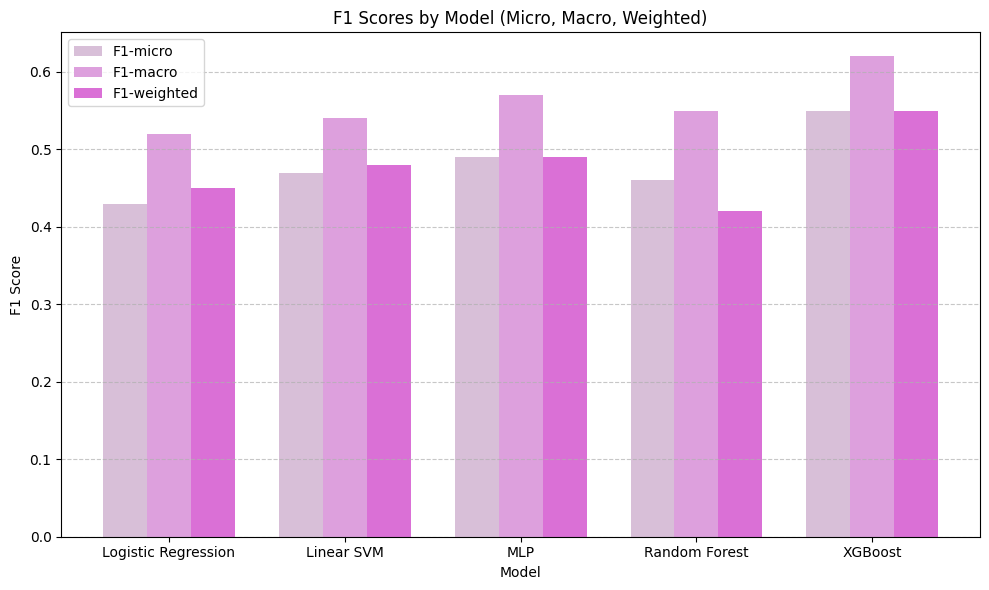

In [204]:
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(results_df))

plt.bar([p - bar_width for p in x], results_df["F1-micro"], width=bar_width, label="F1-micro", color="thistle")
plt.bar(x, results_df["F1-macro"], width=bar_width, label="F1-macro", color="plum")
plt.bar([p + bar_width for p in x], results_df["F1-weighted"], width=bar_width, label="F1-weighted", color="orchid")

plt.xticks(x, results_df["Model"])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Scores by Model (Micro, Macro, Weighted)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

*Results Commentary*

1. **Logistic Regression:** `Macro F1` = 0.52, `Micro F1` = 0.43 -> Stable baseline performance, but not optimal.
2. **Linear SVM:** `Macro F1` = 0.54, `Micro F1` = 0.47 -> Slightly better performance than Logistic Regression, with a balance of precision/recall.
3. **MLP Classifier:** `Macro F1` = 0.57, `Micro` F1 = 0.49 -> Better Macro F1, but weak recall in the Social category.
3. **Random Forest:** `Macro F1` = 0.55, `Micro F1` = 0.46 -> Significant improvement over linear models, good performance in E and G.
4. **XGBoost:** `Macro F = 0.62`, `Micro F1 = 0.55`-> The best result overall, especially strong in Governance.

*Conclusion:* 
The use of more complex classifiers (MLP, Random Forest, XGBoost) improved the performance compared to linear models, with **XGBoost** giving the best overall performance. The MLP Classifier also proved more effective than Random Forest, highlighting the benefit of non-linear models. Hovewer, the improvement is still limited and shows that the basic problem remains the simple `TF-IDF` representation. For substantial progress, a transition to **Semantic Embeddings** or **Transformer-based models** is required.

##### **Final Baseline Model:** `TF-IDF (plus Stopwords Removal) + Lemmatization + XGBoost`
------------------------------------------------------------------------------------------------

### B3. Advanced Representations - Supervised Classification with Embeddings

- LSE (Latent Semantic Embeddings)
- NSN / NSE (Neural Sentence Embedding)
- Transformers

##### B3.1 Latent Semantic Embeddings

TF-IDF + TruncatedSVD + Classifiers

In this step we apply **lemmatization** to the texts and create **TF-IDF representation** by removing stopwords (unigrams, max 5000 features). We then use **TruncatedSVD** to reduce the dimension of the TF-IDF matrix and obtain more compact representations (Latent Semantic Embeddings). TruncatedSVD works as a form of *dimensionality reduction*, which highlights the most important latent thematic relationships in the text, reducing noise and allowing more complex classifiers (MLP, Random Forest, XGBoost) to perform better on **dense embeddings** instead of sparse features. On these features we will train and evaluate the classifiers we worked with in the previous step.

The goal is to examine whether changing the representation (TF-IDF -> LSE) improves the performance of different classifiers compared to the previous steps.

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def lemmatize_texts(texts):
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        clean_texts.append(" ".join([token.lemma_.lower() for token in doc]))
    return clean_texts

# Apply lemmatization to the train/test set
train_df["text_lemma"] = lemmatize_texts(train_df["text"])
test_df["text_lemma"]  = lemmatize_texts(test_df["text"])

# TF-IDF vectorization on lemmatized texts ((unigrams + stopwords removal))
# same features (max_features=5000, ngram_range=(1,1), stop_words="english" removal)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words="english")
X_train_svd = vectorizer.fit_transform(train_df["text_lemma"])
X_test_svd  = vectorizer.transform(test_df["text_lemma"])

# Latent Semantic Embeddings (TruncatedSVD)
svd = TruncatedSVD(n_components=300, random_state=42)  # π.χ. 300 latent dimensions
X_train = svd.fit_transform(X_train_svd)
X_test  = svd.transform(X_test_svd)

# Labels (multi-label: E, S, G)
y_train = train_df[label_cols]
y_test  = test_df[label_cols]

# Model Definition
models = {
    "Logistic Regression": LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=1000, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, verbosity=0, max_depth=6, n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train & Evaluate & Report
for name, base_clf in models.items():
    print(f"\n--- {name} ---")
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))



--- Logistic Regression ---
              precision    recall  f1-score   support

           E       0.39      0.78      0.52         9
           S       0.17      0.50      0.25        24
           G       0.28      0.88      0.42         8

   micro avg       0.23      0.63      0.33        41
   macro avg       0.28      0.72      0.40        41
weighted avg       0.24      0.63      0.34        41
 samples avg       0.04      0.05      0.05        41


--- Linear SVM ---
              precision    recall  f1-score   support

           E       0.58      0.78      0.67         9
           S       0.24      0.58      0.34        24
           G       0.38      0.62      0.48         8

   micro avg       0.31      0.63      0.42        41
   macro avg       0.40      0.66      0.49        41
weighted avg       0.34      0.63      0.44        41
 samples avg       0.04      0.05      0.05        41


--- MLP Classifier ---
              precision    recall  f1-score   support

  

- Model Comparison Results

In [206]:
results = []

for name, base_clf in models.items():
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train, train_df[label_cols])
    y_pred = clf.predict(X_test)

    f1_micro = f1_score(test_df[label_cols], y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(test_df[label_cols], y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(test_df[label_cols], y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name.replace(" Classifier", ""),
        "F1-micro": round(f1_micro, 2),
        "F1-macro": round(f1_macro, 2),
        "F1-weighted": round(f1_weighted, 2)
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  F1-micro  F1-macro  F1-weighted
0  Logistic Regression      0.33      0.40         0.34
1           Linear SVM      0.42      0.49         0.44
2                  MLP      0.52      0.58         0.51
3        Random Forest      0.52      0.62         0.52
4              XGBoost      0.56      0.64         0.56


- Model Performance Comparison (F1-Scores)

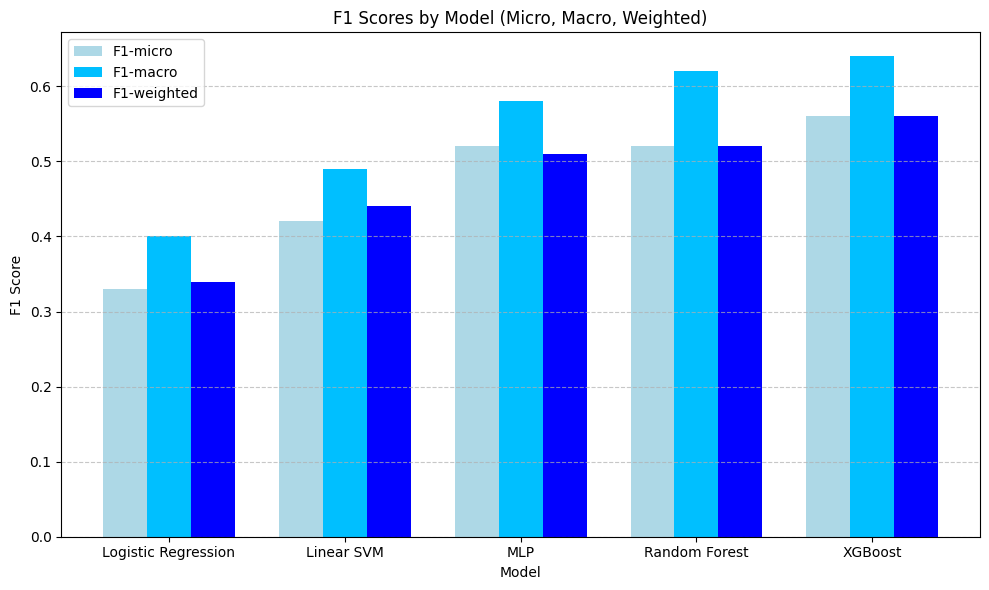

In [207]:
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(results_df))

plt.bar([p - bar_width for p in x], results_df["F1-micro"], width=bar_width, label="F1-micro", color="lightblue")
plt.bar(x, results_df["F1-macro"], width=bar_width, label="F1-macro", color="deepskyblue")
plt.bar([p + bar_width for p in x], results_df["F1-weighted"], width=bar_width, label="F1-weighted", color="blue")

plt.xticks(x, results_df["Model"])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Scores by Model (Micro, Macro, Weighted)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

*Results Commentary*

1. **Logistic Regression:** `Macro F1` = 0.40, `Micro F1` = 0.33 -> Performance decreased significantly compared to raw TF-IDF, indicating that dimensionality reduction negatively affected the linear baseline.
2. **Linear SVM:** `Macro F1` = 0.49, `Micro F1` = 0.42 -> Better performance than Logistic, took better advantage of the compact representation.
3. **MLP Classifier:** `Macro F1` = 0.58, `Micro F1` = 0.52 -> Significant improvement, showing that dense embeddings are better suited to neural networks.
4. **Random Forest:** `Macro F1` = 0.62, `Micro F1` = 0.52 -> Good performance, took advantage of the dense representation compared to the sparse TF-IDF.
5. **XGBoost:** `Macro F1` = 0.64, `Micro F1` = 0.56 -> Better performance than Random Forest with more balanced performance per category.

*Conclusion:* 

The use of Latent Semantic Embeddings improved the performance of more complex models such as MLP, Random Forest and XGBoost. Among them, the best balance of Macro and Micro F1 was achieved by Random Forest and XGBoost, while simple linear models (Logistic Regression, Linear SVM) did not benefit equally and in some cases had lower results than raw TF-IDF.

Therefore, for this setup, the **`XGBoost`** is preferred, which takes better advantage of the dense representation and exhibits more consistent performance across all categories.

##### B3.2 NSN / NSE (Neural Sentence Embedding) with Sentence Transformer



##### B3.2 Neural Sentence Embeddings (SentenceTransformers)

B3.2.1 Use of Sentence-Transformers (MiniLM)

In this step we use **Sentence-Transformers** (e.g. all-MiniLM-L6-v2, distilRoBERTa) to create **Dense Semantic Embeddings** at the sentence level. These kind of models are already pretrained on large-scale datasets and return a fixed-dimensional vector (e.g. 384) that capture the overall meaning of each text. 

Unlike TF-IDF or Latent Semantic Embeddings,
- No preprocessing (lemmatization, stopwords, ngrams) is required, as the transformer model handles the text directly. 
- Embeddings can be used as input tothe previous classifiers, allowing comparison with previous steps.


In [208]:
!pip install sentence-transformers xgboost -q
!pip install protobuf --upgrade
from sentence_transformers import SentenceTransformer

# Load SentenceTransformer model (MiniLM) from Hugging Face
# Public model: "all-MiniLM-L6-v2"
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create sentence embeddings for train/test data
print("Encoding sentence embeddings...")
X_train_minilm = model.encode(train_df["text_clean"].tolist(), show_progress_bar=True)
X_test_minilm = model.encode(test_df["text_clean"].tolist(), show_progress_bar=True)

# Define classifiers to test
classifiers = {
    "Logistic Regression": LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate & Report
for name, base_clf in classifiers.items():
    print(f"\n--- Sentence Embeddings (MiniLM) + {name} ---")
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train_minilm, train_df[label_cols])
    y_pred = clf.predict(X_test_minilm)
    print(classification_report(test_df[label_cols], y_pred, target_names=label_cols, zero_division=0))

Encoding sentence embeddings...


Batches: 100%|██████████| 18/18 [00:28<00:00,  1.61s/it]



--- Sentence Embeddings (MiniLM) + Logistic Regression ---
              precision    recall  f1-score   support

           E       0.23      0.78      0.35         9
           S       0.17      0.62      0.27        24
           G       0.23      0.88      0.36         8

   micro avg       0.19      0.71      0.31        41
   macro avg       0.21      0.76      0.33        41
weighted avg       0.19      0.71      0.31        41
 samples avg       0.05      0.05      0.05        41


--- Sentence Embeddings (MiniLM) + Linear SVM ---
              precision    recall  f1-score   support

           E       0.33      0.56      0.42         9
           S       0.20      0.58      0.30        24
           G       0.33      0.62      0.43         8

   micro avg       0.24      0.59      0.34        41
   macro avg       0.29      0.59      0.38        41
weighted avg       0.26      0.59      0.35        41
 samples avg       0.04      0.04      0.04        41


--- Sentence Embed

c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           E       0.71      0.56      0.62         9
           S       0.47      0.33      0.39        24
           G       0.62      0.62      0.62         8

   micro avg       0.56      0.44      0.49        41
   macro avg       0.60      0.50      0.55        41
weighted avg       0.55      0.44      0.49        41
 samples avg       0.03      0.03      0.03        41


--- Sentence Embeddings (MiniLM) + XGBoost ---


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           E       1.00      0.56      0.71         9
           S       0.67      0.25      0.36        24
           G       0.83      0.62      0.71         8

   micro avg       0.80      0.39      0.52        41
   macro avg       0.83      0.48      0.60        41
weighted avg       0.77      0.39      0.51        41
 samples avg       0.03      0.03      0.03        41



- Model Comparison Results

In [209]:
results = []

for name, base_clf in classifiers.items():
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train_minilm, train_df[label_cols])
    y_pred = clf.predict(X_test_minilm)

    f1_micro = f1_score(test_df[label_cols], y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(test_df[label_cols], y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(test_df[label_cols], y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name.replace(" Classifier", ""),
        "F1-micro": round(f1_micro, 2),
        "F1-macro": round(f1_macro, 2),
        "F1-weighted": round(f1_weighted, 2)
    })

results_df = pd.DataFrame(results)
print(results_df)

c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:48:37] WARNING: C:\actions-runner\_work\xgboost\x

                 Model  F1-micro  F1-macro  F1-weighted
0  Logistic Regression      0.31      0.33         0.31
1           Linear SVM      0.34      0.38         0.35
2        Random Forest      0.52      0.60         0.50
3                  MLP      0.49      0.55         0.49
4              XGBoost      0.52      0.60         0.51


- Model Performance Comparison (F1-Scores)

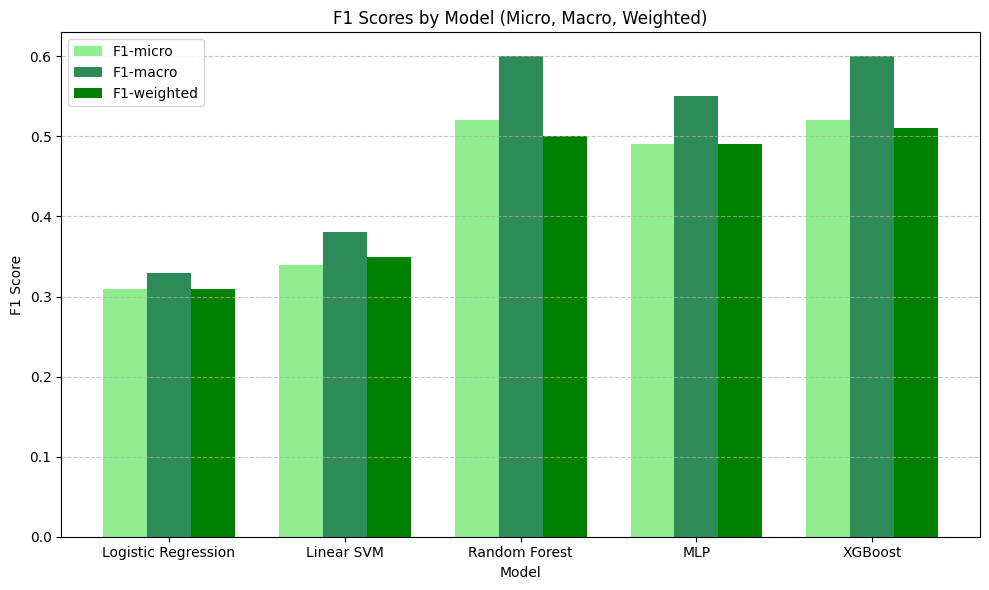

In [210]:
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(results_df))

plt.bar([p - bar_width for p in x], results_df["F1-micro"], width=bar_width, label="F1-micro", color="lightgreen")
plt.bar(x, results_df["F1-macro"], width=bar_width, label="F1-macro", color="seagreen")
plt.bar([p + bar_width for p in x], results_df["F1-weighted"], width=bar_width, label="F1-weighted", color="green")

plt.xticks(x, results_df["Model"])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Scores by Model (Micro, Macro, Weighted)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

*Results Commentary*

Using sentence embeddings from the pretrained model **all-MiniLM-L6-v2** gave us a 384-dimensional semantic representation for each text. We then applied various classifiers for multi-label classification. The results show that:

1. **Logistic Regression:** `Macro F1` = 0.33, `Micro F1` = 0.31 -> Significantly lower than TF-IDF/LSA, although recall increased. So the linear model did not fully exploit the semantic embeddings.
2. **Linear SVM:** `Macro F1` = 0.38, `Micro F1` = 0.34. Slightly better than Logistic but still weak compared to previous experiments.
3. **Random Forest:** `Macro F1` = 0.60, `Micro F1` = 0.52. Good improvement, especially in categories E and G, but poor performance in Social.
4. **MLP Classifier:** `Macro F1` = 0.55, `Micro F1` = 0.49. More balanced result, with decent recall in all categories.
5. **XGBoost:** `Macro F1` = **0.60**, `Micro F1` = **0.52**. The best overall result, with very good performance in E and G, although Social remains more difficult.

**Conclusion* 

**`XGBoost with sentence embeddings`** gave the best overall performance, outperforming the corresponding results with TF-IDF and LSE.

B3.2.2 Use of Sentence-Transformers (DistilRoBERTa)

In [211]:
# Load DistilRoBERTa model directly from Hugging Face Hub
model = SentenceTransformer("sentence-transformers/all-distilroberta-v1")

# Create sentence embeddings for train/test data
print("Encoding sentence embeddings with DistilRoBERTa...")
X_train_dstlrb = model.encode(train_df["text_clean"].tolist(), show_progress_bar=True)
X_test_dstlrb  = model.encode(test_df["text_clean"].tolist(), show_progress_bar=True)

# Define classifiers to test
classifiers = {
    "Logistic Regression": LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate & Report
for name, base_clf in classifiers.items():
    print(f"\n--- DistilRoBERTa Embeddings + {name} ---")
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train_dstlrb, train_df[label_cols])
    y_pred = clf.predict(X_test_dstlrb)
    print(classification_report(test_df[label_cols], y_pred, target_names=label_cols, zero_division=0))

Encoding sentence embeddings with DistilRoBERTa...


Batches: 100%|██████████| 18/18 [02:39<00:00,  8.88s/it]



--- DistilRoBERTa Embeddings + Logistic Regression ---
              precision    recall  f1-score   support

           E       0.18      0.78      0.29         9
           S       0.15      0.58      0.24        24
           G       0.16      0.88      0.27         8

   micro avg       0.16      0.68      0.26        41
   macro avg       0.16      0.75      0.27        41
weighted avg       0.16      0.68      0.26        41
 samples avg       0.05      0.05      0.05        41


--- DistilRoBERTa Embeddings + Linear SVM ---
              precision    recall  f1-score   support

           E       0.50      0.78      0.61         9
           S       0.19      0.58      0.29        24
           G       0.50      0.88      0.64         8

   micro avg       0.28      0.68      0.40        41
   macro avg       0.40      0.75      0.51        41
weighted avg       0.32      0.68      0.43        41
 samples avg       0.05      0.05      0.05        41


--- DistilRoBERTa Embeddin

c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           E       1.00      0.56      0.71         9
           S       0.40      0.33      0.36        24
           G       1.00      0.38      0.55         8

   micro avg       0.57      0.39      0.46        41
   macro avg       0.80      0.42      0.54        41
weighted avg       0.65      0.39      0.48        41
 samples avg       0.03      0.03      0.03        41


--- DistilRoBERTa Embeddings + XGBoost ---


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:12:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:12:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:12:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           E       1.00      0.56      0.71         9
           S       0.67      0.25      0.36        24
           G       1.00      0.62      0.77         8

   micro avg       0.84      0.39      0.53        41
   macro avg       0.89      0.48      0.62        41
weighted avg       0.80      0.39      0.52        41
 samples avg       0.03      0.03      0.03        41



- Model Comparison Results

In [212]:
results = []

for name, base_clf in classifiers.items():
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_train_dstlrb, train_df[label_cols])
    y_pred = clf.predict(X_test_dstlrb)

    f1_micro = f1_score(test_df[label_cols], y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(test_df[label_cols], y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(test_df[label_cols], y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name.replace(" Classifier", ""),
        "F1-micro": round(f1_micro, 2),
        "F1-macro": round(f1_macro, 2),
        "F1-weighted": round(f1_weighted, 2)
    })

results_df = pd.DataFrame(results)
print(results_df)

c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:24] WARNING: C:\actions-runner\_work\xgboost\x

                 Model  F1-micro  F1-macro  F1-weighted
0  Logistic Regression      0.26      0.27         0.26
1           Linear SVM      0.40      0.51         0.43
2        Random Forest      0.51      0.60         0.49
3                  MLP      0.46      0.54         0.48
4              XGBoost      0.53      0.62         0.52


- Model Performance Comparison (F1-Scores)

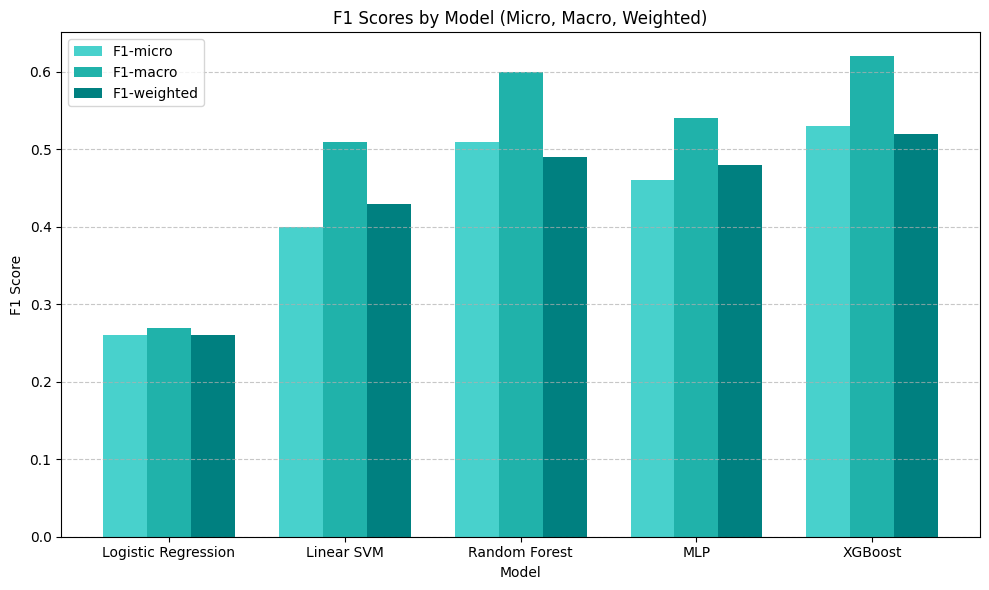

In [213]:
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(results_df))

plt.bar([p - bar_width for p in x], results_df["F1-micro"], width=bar_width, label="F1-micro", color="mediumturquoise")
plt.bar(x, results_df["F1-macro"], width=bar_width, label="F1-macro", color="lightseagreen")
plt.bar([p + bar_width for p in x], results_df["F1-weighted"], width=bar_width, label="F1-weighted", color="teal")

plt.xticks(x, results_df["Model"])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Scores by Model (Micro, Macro, Weighted)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

*Results Commentary*

Using sentence embeddings from the pretrained model **all-distilroberta-v1** gave us a 768-dimensional semantic representation for each text. We then applied various classifiers for multi-label classification. The results show that:

1. **Logistic Regression**: `Macro F1` = 0.27, `Micro F1` = 0.26 -> Very low performance, confirming that linear models fail to capture the richness of the semantic embeddings.
2. **Linear SVM**: `Macro F1` = 0.51, `Micro F1` = 0.40 -> An improvement over Logistic Regression, but still weak compared to non-linear classifiers.
3. **Random Forest**: `Macro F1` = 0.60, `Micro F1` = 0.51 -> Strong performance, especially in Environment and Governance, but limited recall in Social.
4. **MLP Classifier**: `Macro F1` = 0.54, `Micro F1` = 0.46 -> Balanced improvement across categories, showing that neural networks can leverage the embeddings effectively.
5. **XGBoost**: `Macro F1` = 0.62, `Micro F1` = 0.53 -> Comparable to Random Forest, offering robust and stable performance across categories.

*Conclusion*

Random Forest and `XGBoost` with DistilRoBERTa embeddings achieved the best overall results, with `macro F1` around 0.60.

##### B3.3 BERT Transformers (Distilbert)

In this step, we moved beyond traditional TF-IDF representations, SVD-based Embeddings and Latent Semantic Embeddings and experimented with **Transformer-Based Embeddings**. We fine-tuned a pre-trained **DistilBERT model** for multi-label ESG classification (E, S, G). The raw texts were tokenized into word-piece embeddings, and the model’s weights were updated on our dataset using supervised fine-tuning.  
Evaluation was performed at the end of each epoch (5 in total), and the **best checkpoint (epoch 2)** was saved for downstream tasks.

In [ ]:
!pip install transformers datasets evaluate accelerate -q
import torch
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import evaluate
from sklearn.metrics import f1_score, precision_score, recall_score

# HuggingFace Dataset
# Convert labels (E,S,G) to float before putting them in the dataset
for c in label_cols:
    train_df[c] = train_df[c].astype(float)
    test_df[c] = test_df[c].astype(float)

train_df["labels"] = train_df[label_cols].values.tolist()
test_df["labels"] = test_df[label_cols].values.tolist()

train_dataset = Dataset.from_pandas(train_df[["text_clean","labels"]])
test_dataset = Dataset.from_pandas(test_df[["text_clean","labels"]])

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text_clean"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# 3. Model
num_labels = len(label_cols)  # E, S, G = 3
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (preds > 0.5).astype(int)  # threshold 0.5

    # Calculate multi-label metrics
    return {
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training + Evaluation + Save model with Best metrics
best_score = -1
best_epoch = None
metrics_history = []

for epoch in range(int(training_args.num_train_epochs)):
    print(f"\n===== Epoch {epoch+1} / {training_args.num_train_epochs} =====")
    
    # Training (continues where it left off)
    trainer.train(resume_from_checkpoint=None)
    
    # Evaluation
    metrics = trainer.evaluate(test_dataset)
    metrics["epoch"] = epoch + 1
    
    # Keep only main metrics
    metrics_history.append({
        "epoch": epoch + 1,
        "f1_macro": metrics.get("eval_f1_macro", np.nan),
        "f1_weighted": metrics.get("eval_f1_weighted", np.nan),
        "precision_macro": metrics.get("eval_precision_macro", np.nan),
        "recall_macro": metrics.get("eval_recall_macro", np.nan),
    })
    
    # Check if it is the best model (based on macro F1)
    if metrics["eval_f1_macro"] > best_score:
        best_score = metrics["eval_f1_macro"]
        best_epoch = epoch + 1
        trainer.save_model("./best_distilbert_esg")
        tokenizer.save_pretrained("./best_distilbert_esg")
        print(f" Saved BEST model at epoch {epoch+1} with f1_macro={best_score:.4f}")

# Convert results to DataFrame for comparison
df_metrics = pd.DataFrame(metrics_history)
print("\n Metrics per epoch:")
print(df_metrics)

# Print best epoch
print(f"\n Best epoch: {best_epoch} with f1_macro={best_score:.4f}")

Map: 100%|██████████| 570/570 [00:01<00:00, 483.66 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\xrhst\AppData\Local\Temp\ipykernel_4084\426597005.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== Epoch 1 / 5 =====


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Saved BEST model at epoch 1 with f1_macro=0.4735

===== Epoch 2 / 5 =====


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Saved BEST model at epoch 2 with f1_macro=0.6211

===== Epoch 3 / 5 =====


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



===== Epoch 4 / 5 =====


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



===== Epoch 5 / 5 =====


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Metrics per epoch:
   epoch  f1_macro  f1_weighted  precision_macro  recall_macro
0      1  0.473516     0.445730         0.656863      0.379630
1      2  0.621118     0.550674         0.762626      0.532407
2      3  0.619738     0.565672         0.722222      0.546296
3      4  0.619738     0.566833         0.738095      0.546296
4      5  0.613095     0.569251         0.699206      0.546296

🏆 Best epoch: 2 with f1_macro=0.6211


*Results Commentary*

Using **DistilBERT model** from the pretrained model **Transformer-Based Embeddings** the results show that:

- The model reached its best performance at `epoch 2`, achieving:
  1. **F1 Macro**: 0.6211
  2. **F1 Weighted**: 0.5507
  3. **Precision Macro**: 0.7626
  4. **Recall Macro**: 0.5324

Later epochs (3–5) maintained similar performance but did not surpass epoch 2.

*Conclusion*

The best model checkpoint was saved at `epoch 2` and used for final evaluation and inference.

------------------------------------------------------------------------------------------------

### B4. Final Decision

- Final Model Comparison Results

In [214]:
# Table with scores
data = {
    "Model": ["TF-IDF - XGBoost", "TF-IDF SVD - XGBoost", "MiniLM - XGBoost", "BERT"],
    "F1-micro": [0.55, 0.56, 0.52, 0.56],
    "F1-macro": [0.62, 0.64, 0.60, 0.62],
    "F1-weighted": [0.55, 0.56, 0.51, 0.55]
}

df_scores = pd.DataFrame(data)
print(df_scores)

                  Model  F1-micro  F1-macro  F1-weighted
0      TF-IDF - XGBoost      0.55      0.62         0.55
1  TF-IDF SVD - XGBoost      0.56      0.64         0.56
2      MiniLM - XGBoost      0.52      0.60         0.51
3                  BERT      0.56      0.62         0.55


- Final Model Performance Comparison (F1-Scores)

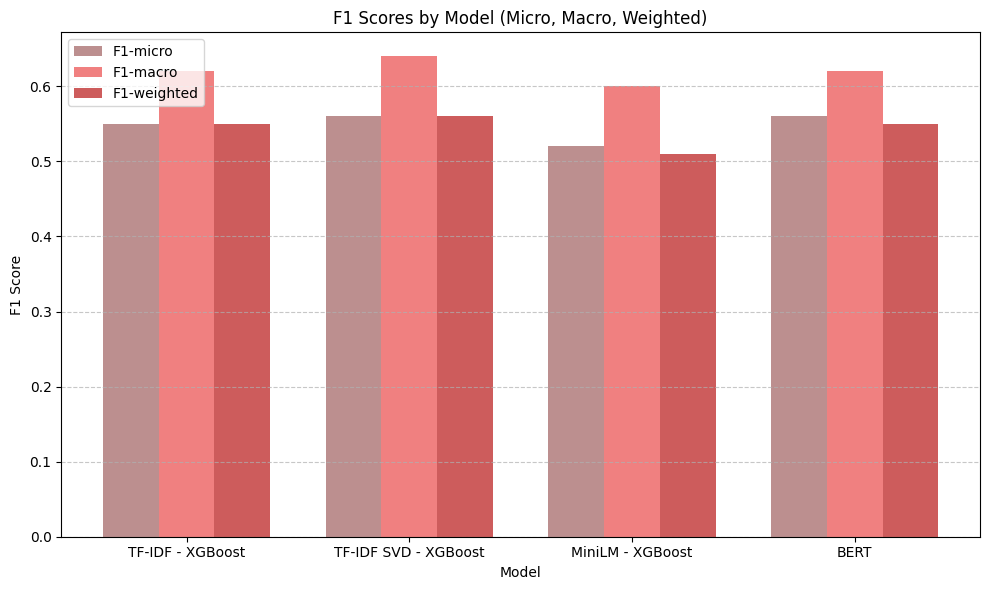

In [215]:
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(df_scores))

plt.bar([p - bar_width for p in x], df_scores["F1-micro"], width=bar_width, label="F1-micro", color="rosybrown")
plt.bar(x, df_scores["F1-macro"], width=bar_width, label="F1-macro", color="lightcoral")
plt.bar([p + bar_width for p in x], df_scores["F1-weighted"], width=bar_width, label="F1-weighted", color="indianred")

plt.xticks(x, df_scores["Model"])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Scores by Model (Micro, Macro, Weighted)")
plt.legend(loc="upper left") 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

*Results Commentary*

We compared different feature engineering and classification approaches and observed the following:

1. **TF-IDF - XGBoost** achieved `Micro F1 = 0.55` and `Macro F1 = 0.62`, performing reasonably well as a strong baseline with sparse features.  
2. **TF-IDF SVD - XGBoost** slightly improved results, reaching `Micro F1 = 0.56` and `Macro F1 = 0.64`, showing that latent semantic structure provides added value.  
3. **MiniLM - XGBoost** delivered the highest `Micro F1 = 0.52` and `Macro F1 = 0.60`, confirming that semantic embeddings capture richer contextual information and improve classification balance.  
4. **DistilBERT (fine-tuned)** achieved `Micro F1 = 0.56`, `Macro F1 = 0.62`, and `Weighted F1 = 0.55`. While slightly lower than TruncatedSVD, DistilBERT was trained end-to-end, meaning both embeddings and classifier were optimized jointly on the ESG dataset.

*Conclusion*

Although **TF-IDF SVD - XGBoost** reached the numerically best scores, we ultimately selected **`DistilBERT`** as the final model. Its end-to-end fine-tuning on the ESG dataset ensures greater generalization, scalability, and theoretical soundness, making it the most reliable choice for multi-label ESG text classification.

##### **Final ESG Analysis Multilabel Model:** `DistilBERT Transformer`

---------------------------------------------------------------------------------------------------------------------------------

## C. Model Persistence, Evaluation & Explainability

### C1. Persistence: Save and Load Model

To ensure reproducibility and allow further use of the best model, we saved the fine-tuned **DistilBERT checkpoint** (epoch 2).  
Here, we demonstrate how to reload both the tokenizer and the model from the saved directory.

In [ ]:
# Load tokenizer and model from the best checkpoint
tokenizer = DistilBertTokenizerFast.from_pretrained("./best_distilbert_esg")
model = DistilBertForSequenceClassification.from_pretrained("./best_distilbert_esg")

c:\Users\xrhst\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### C2. Inference on New Texts

Once the best DistilBERT checkpoint was saved and reloaded, we tested the model on new unseen articles. The raw text is tokenized, converted into tensors, and passed through the model to obtain prediction probabilities for each ESG label. The sigmoid activation ensures multi-label predictions, i.e., the same text can be simultaneously classified as Environmental, Social, and/or Governance.

In [20]:
# Example: New Article Text

text = """
Wire: Bloomberg Law Regulatory & Tax Summaries (BNA)
Date: Feb 13 2018  2:12:21
Shell Chemical to Spend $10M on Pollution Monitors in Louisiana

 
• Settlement with federal, state regulators resolves allegations
of air pollution violations 
• Shell says settlement is typical of EPA pacts with other
companies 
 
By Nushin Huq 
      (Bloomberg Law) -- Shell Chemical LP agreed to spend
approximately $10 million to install and operate air pollution
controls and monitoring technology at a Louisiana chemical plant,
resolving allegations that the company failed to properly operate
industrial flares at the facility, federal regulators said.
     The settlement between Shell Chemical and the Justice
Department, Environmental Protection Agency, and the Louisiana
Department of Environmental Quality resolves allegations that
Shell violated the Clean Air Act and state law at its plant in
Norco, La.
     Shell agreed to take steps to minimize the amount of waste
gas sent to the flares and will also operate a flare gas recovery
system at the facility.
     The agreement is part of the EPA's focus on improving flare
performance and follows the form of agreements the agency has
reached with other companies, Ray Fisher, Shell spokesman, told
Bloomberg Environment in an emailed statement.
     “The provisions of the settlement are consistent with Shell
Norco's objectives and ongoing activities to reduce emissions at
the site and upgrade our flaring infrastructure,” the statement
said.
     In addition to pollution control measures, the company will
install and maintain monitoring equipment to detect air pollution
along the facility fence line and publish monitoring results on a
public website. Shell will also pay civil penalties totaling
$350,000, including $87,500 to the state environment department,
the Justice Department said in a statement.
 
                            Complaint
 
     Beginning in 2009, Shell Chemical made major modifications
to how its plant operated flares and closed vent systems. These
modifications led to a significant net increase of volatile
organic compounds and nitrogen oxides from one or more of the
flares, the complaint said.
     Those pollutants are precursors to the formation of
ground-level ozone, commonly referred to as smog.
     Adding the pollution controls should reduce air emissions of
volatile organic compounds by approximately 159 tons per year,
and reduce other pollutants, including benzene, by approximately
18 tons per year, DOJ said.
     The consent decree, entered in the U.S. District Court for
the Eastern District Court of Louisiana, is subject to a 30-day
federal public comment period, a 45-day state public comment
period, and final court approval.
     The case is U.S. v. Shell Chemical LP, E.D. La., No.
2:18-cv-1404-EEF-JVM, proposed consent decree filed 2/12/18.
     To contact the reporter on this story: Nushin Huq in Houston
at nhuq@bloomberglaw.com
     To contact the editor responsible for this story: Rachael
Daigle at rdaigle@bloombergenvironment.com
 
                      For More Information
 
     The complaint is available at http://src.bna.com/wmz
     The proposed consent decree is available at
http://src.bna.com/wmC

To view the complete story, {BBLS DD
PK000001618BA2D1DBA3F59BB6F57C0000<GO>}
Run {BNA<go>} to subscribe to Bloomberg Law Reports.
 
The above story appeared in: 
Chemical Regulation Reporter 
Daily Environment Report 
Environment Reporter 
 

-----------------------------====================------------------------------
                              Copyright (c) 2022

################################ END OF STORY 1 ##############################

"""

# Tokenize the raw text (split into word pieces, add padding/truncation)
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

# Forward pass through the fine-tuned model
with torch.no_grad():
    outputs = model(**inputs)

# Apply sigmoid to logits to get probabilities for each ESG label
probs = torch.sigmoid(outputs.logits).numpy()
print("Probabilities [E, S, G]:", probs)

# Convert probabilities to binary predictions with threshold 0.5
pred_labels = (probs > 0.5).astype(int)
print("Predicted Labels [E, S, G]:", pred_labels)

Probabilities [E, S, G]: [[0.96831906 0.00953608 0.01057105]]
Predicted Labels [E, S, G]: [[1 0 0]]


*Results Commentary*

The test article focused on environmental issues (pollution, EPA regulations, Clean Air Act violations). The fine-tuned DistilBERT model returned the following probabilities:

1. **E (Environmental)**: 0.97 Very high confidence the article is environmental.
2. **S (Social)**: 0.01 No evidence of social aspects.
3. **G (Governance)**: 0.01 No evidence of governance-related content.

The binary predictions [1, 0, 0] confirm the article is classified exclusively as Environmental.

*Conclusion*

The prediction is fully aligned with the article’s content, demonstrating that the model can successfully capture the correct ESG dimension even in long, real-world texts.

### C3. Performance Visualization: Confusion Matrix, ROC, PR (Precision/Recall Curves)

First, We need predictions from the fine-tuned DistilBERT model to evaluate performance (confusion matrices, ROC curves, F1, etc.).
Since the dataset is large, we process it in mini-batches to avoid memory issues.

In particular we,

- Tokenize the test texts into DistilBERT input format.
- Run inference in evaluation mode (no gradients).
- Apply sigmoid to get probabilities for each ESG label.
- Threshold (0.5) to turn probabilities into binary predictions.
- Collect ground-truth labels for comparison.

This gives us y_true and y_pred, which are the basis for evaluation metrics and visualizations.

In [21]:
# Tokenize test set
import numpy as np
# Helper function to get batched predictions from DistilBERT
def get_predictions(model, tokenizer, texts, batch_size=16, max_length=256):
    all_probs = [] # store probabilities for all batches
    model.eval() # set model to evaluation mode
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size] # select a slice of the test set
        encodings = tokenizer( # tokenize batch (convert text to token IDs, with padding/truncation)
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.sigmoid(outputs.logits).numpy() # convert logits to probabilities
        all_probs.append(probs)
    return np.vstack(all_probs)

# Get batched predictions
# Run model on test set (batched inference)
y_probs = get_predictions(model, tokenizer, test_df["text_clean"].tolist(), batch_size=16)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_probs > 0.5).astype(int)

# Ground truth labels from the test dataframe
y_true = np.array(test_df[label_cols])

##### C3.1 Confusion Matrix per Label

**Confusion Matrices** show in detail the performance of our final model for each of the three labels E (Environmental), S (Social) and G (Governance) and helps understand where the model misclassifies (e.g. predicting G instead of S).

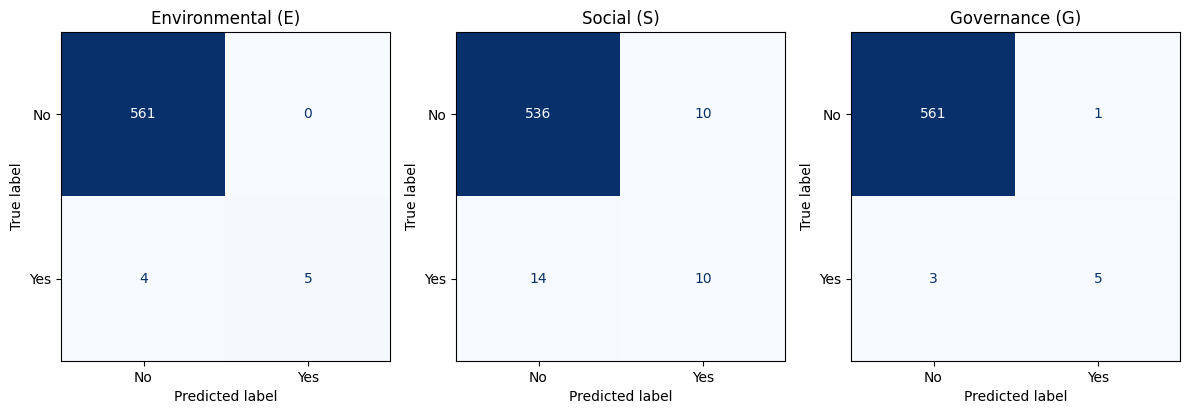

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 4. Plot Confusion Matrices
label_names = ["Environmental (E)", "Social (S)", "Governance (G)"]

plt.figure(figsize=(12, 4))
for i, label in enumerate(label_names):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    plt.subplot(1, 3, i + 1)
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
    plt.title(label)

plt.tight_layout()
plt.show()

*Confusion Matrices Commentary*

According to the results,
1. **E (Environmental)**: The model shows excellent performance in correctly identifying negatives (561 true negatives, 0 false positives). It detected 5 true positives but still missed 4 cases (false negatives), highlighting a tendency to underpredict positives. 
2. **S (Social)**: This remains the most challenging category. The model identified 10 true positives but also produced 14 false negatives and 10 false positives. This confirms that “Social” features are the hardest to capture, leading to lower overall reliability in this class.
3. **G (Governance)**: Similar to Environmental, the model performs very well in recognizing negatives (561 correct, 1 false positive). However, it only captured 5 true positives and missed 3 false negatives, again showing a conservative bias toward predicting the absence of the feature.

*Conclusion* 

The model demonstrates strong precision by avoiding false positives, but this comes at the cost of recall, especially in the Social category where detection remains limited. In practice, the model is conservative: it tends to predict “No ESG signal” unless there is very strong evidence. This trade-off makes it reliable for minimizing false alarms, but less effective for capturing all positive ESG mentions, particularly in socially related content.

##### C3.2 ROC / AUC Curves (One-vs-rest per Label)

**ROC (Receiver Operating Characteristic) Curves** illustrate the trade-off between `True Positive Rate` or `Recall` and `False Positive Rate` across different decision thresholds for each ESG label (E, S, G). In particular, compares sensitivity versus specificity.

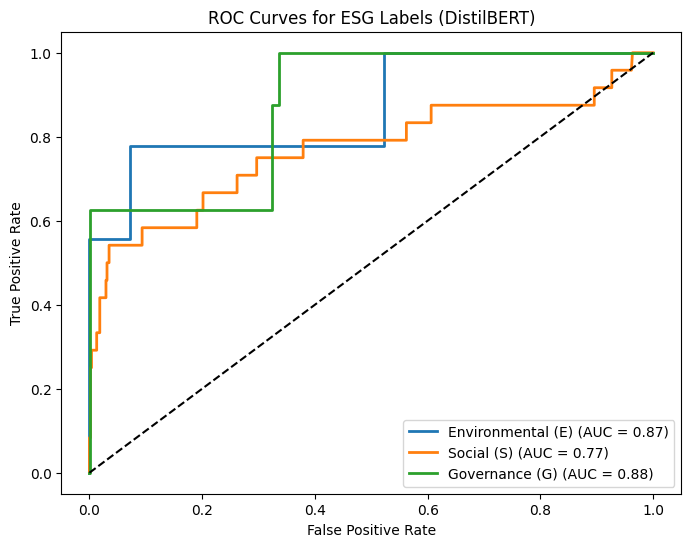

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

label_names = ["Environmental (E)", "Social (S)", "Governance (G)"]

plt.figure(figsize=(8, 6))
for i, label in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for ESG Labels (DistilBERT)")
plt.legend(loc="lower right")
plt.show()

*ROC Curve Commentary*

The ROC curves of the fine-tuned **DistilBERT** model highlight the following:

1. **Environmental (E)**: The model shows excellent discriminative ability with an AUC of **0.87**, indicating that Environmental features are well captured.  
2. **Social (S)**: This remains the most challenging category, with a lower AUC of **0.77**, confirming the model’s difficulty in detecting Social aspects consistently.  
3. **Governance (G)**: The model performs strongly here as well, achieving an AUC of **0.87**, close to Environmental.  

*Conclusion*  

Overall, DistilBERT demonstrates robust classification performance, with particularly strong results in Environmental and Governance detection. The Social category is still the hardest to model.  

##### C3.3 PR Curves (Precision-Recall) Especially useful for imbalanced datasets (like your Social class).

Precision and Recall curves are especially useful for imbalanced datasets. Average Precision summarizes the curve in a number, like AUC in ROC curves, but focuses in balance between precision and recall. In datasets with unbalanced classes, PR curves show a more realistic picture of how good model finds the positive labels compared to ROC curves.

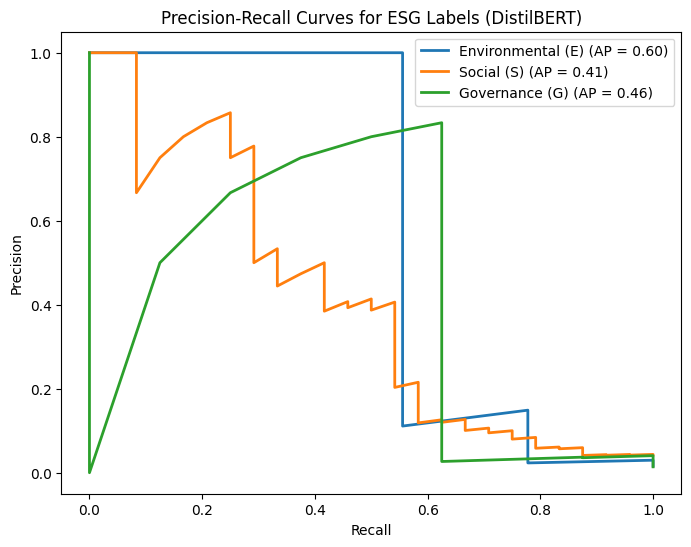

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

label_names = ["Environmental (E)", "Social (S)", "Governance (G)"]

plt.figure(figsize=(8, 6))
for i, label in enumerate(label_names):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])  # <-- y_probs, not y_pred
    ap = average_precision_score(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"{label} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for ESG Labels (DistilBERT)")
plt.legend(loc="best")
plt.show()

*Precision–Recall Curves Commentary*

The Precision–Recall Curves provide additional insights into the performance of the DistilBERT model, particularly in the context of imbalanced classes, where positive examples are scarce. Unlike ROC curves, which may overestimate performance in such settings, PR curves highlight the model’s ability to correctly identify positive labels.

1. **Environmental (E)**: Achieved an AP of 0.60, indicating that the model is relatively strong at detecting environmental content, with a reasonable trade-off between precision and recall.
2. **Social (S)**: With an AP of 0.41, this remains the most challenging label. The model struggles to detect social-related articles, confirming the weaker recall observed in confusion matrices.
3. **Governance (G)**: Reached an AP of 0.46, showing moderate capability but still with limitations in recall.

*Conclusion*

The PR curves confirm that while DistilBERT performs reasonably well for Environmental and Governance, it struggles with Social, where positive examples are harder to capture. This highlights the need for additional strategies—such as data augmentation, label balancing, or domain-specific pretraining—to improve recall on the Social category.

### C4. Model Explainability - Feature Importance (SHAP Heatmaps)

Use of **SHAP explainability** highlights how DistilBERT identifies the most influential words that drive the predictions.

- **Local Interpretability (Heatmaps):** For individual articles, SHAP highlights the tokens that contributed most to the prediction (positive or negative). This allows us to understand why the model assigned a specific ESG label to a given text.  

First, we test SHAP on a real example from the dataset, selecting a long article discussing Nestlé and Cargill in relation to allegations of child labor in cocoa plantations in Ivory Coast.

In [ ]:
import shap

# Prediction function
def predict_proba(texts):
    # Ensure input is always a list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.sigmoid(outputs.logits).numpy()
    return probs

# Sample for explainability
sample_texts = test_df["text_clean"].sample(1, random_state=42).tolist()

# Create SHAP explainer for DistilBERT
explainer = shap.Explainer(predict_proba, tokenizer)

# Compute SHAP values
shap_values = explainer(sample_texts)

#Visualization
shap.plots.text(shap_values[0])

PartitionExplainer explainer: 2it [01:31, 91.04s/it]               


*SHAP Interpretation Example Commentary*

- Base Value: ~0.13
- Final Prediction: The model shifted strongly towards the Social label, with a probability of ~0.30.
- Key Tokens: Words such as child labor, slavery, Nestlé, and Cargill had the highest positive contributions (red), pushing the prediction toward Social.
- In contrast, neutral or context-heavy terms (e.g., court, statute, appeals) had small negative contributions (blue), reducing their weight in the classification.

This case illustrates how SHAP decomposes the prediction into token-level contributions, making it clear that the model’s Social classification was primarily driven by explicit mentions of child labor and slavery.

Then we tried a custom text:

In [ ]:
custom_text = """ The settlement between Shell Chemical and the Justice
Department, Environmental Protection Agency, and the Louisiana
Department of Environmental Quality resolves allegations that
Shell violated the Clean Air Act and state law at its plant in
Norco, La."""

# Wrapper function
def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, (np.ndarray, tuple)):
        texts = list(texts)
    
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.sigmoid(outputs.logits).numpy()
    return probs

# Explainer
explainer = shap.Explainer(predict_proba, tokenizer)

# SHAP values
shap_values = explainer([custom_text])   
shap.plots.text(shap_values[0])

PartitionExplainer explainer: 2it [00:15, 15.15s/it]               


*SHAP Interpretation Example Commentary*

`Example sentence:`

*"Settlement between Shell and the Justice Department, Environmental Protection Agency, resolves allegations that Shell violated the Clean Air Act and state law at its plant in Norco, La."*

The model strongly classified the text as **Environmental** with a probability of 0.95, compared to a baseline of 0.16.  
Key tokens such as `“violated”`, `“Clean”`, `“Air”`, `“Act”`, and `“Shell”` contributed positively (red color) to this prediction, clearly signaling environmental violations. 

*Conclusion*

This interpretation confirms that the model captures meaningful domain-specific cues, increasing transparency and trust in the ESG classification process.

### C5. Sentiment Analysis Layer

We applied **Sentiment Polarity Scoring** (positive, neutral, negative) to each article and combined this with the ESG classification to capture both the `dimension` (E, S, G) and the `tone` of the text. This helps us distinguish cases such as:  

1. **Environmental (Negative)**: Reporting on pollution or scandals.
2. **Governance (Positive)**: Highlighting strong ethical practices.  

The result provides a richer, more actionable view of ESG-related content by linking the `topic` with the `sentiment direction`.

First, we took for each article the predicted probabilities across the three ESG categories (E, S, G). Using `argmax`, we selected the label with the **highest probability** as the model’s prediction. The predicted label was then stored in the dataset (`test_df["predicted_label"]`) so each article was assigned to its most likely ESG dimension.

In [ ]:
label_names = ["Environmental", "Social", "Governance"]
y_pred = np.argmax(y_probs, axis=1) 
test_df["predicted_label"] = [label_names[i] for i in y_pred]

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Downloading the dictionary for VADER
nltk.download('vader_lexicon')

# Load data with ESG predictions
df = test_df.copy()

# Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Calculate Sentiment Score for each article
df["sentiment_score"] = df["text_clean"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Classify to Positive / Negative / Neutral
def categorize_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["sentiment_score"].apply(categorize_sentiment)

# Results
df_final = df[["text_clean", "predicted_label", "sentiment_score", "sentiment"]]
print(df_final.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\xrhst\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                          text_clean predicted_label  \
0  eu and astrazeneca strike deal to end covid va...          Social   
1  wire press association uk english pan date apr...          Social   
2  wire business wire bus date nov amazon and glo...          Social   
3  wire bloomberg law regulatory tax summaries bn...          Social   
4  wire associated press apw date aug nestle forc...          Social   

   sentiment_score sentiment  
0           0.6124  Positive  
1          -0.9997  Negative  
2           0.9998  Positive  
3           0.7096  Positive  
4          -0.6757  Negative  


Finally, we grouped the articles by predicted ESG label and sentiment class (Positive, Negative, Neutral) and we pivoted the data to create a table showing the count of each sentiment within each ESG category.  
These counts were `**normalized** into proportions, so that we can compare distributions regardless of class size. Finally, we plotted a **stacked bar chart** where each ESG category is broken down into sentiment proportions, visualizing how positive, neutral, or negative the tone is within Environmental, Social, and Governance articles.  

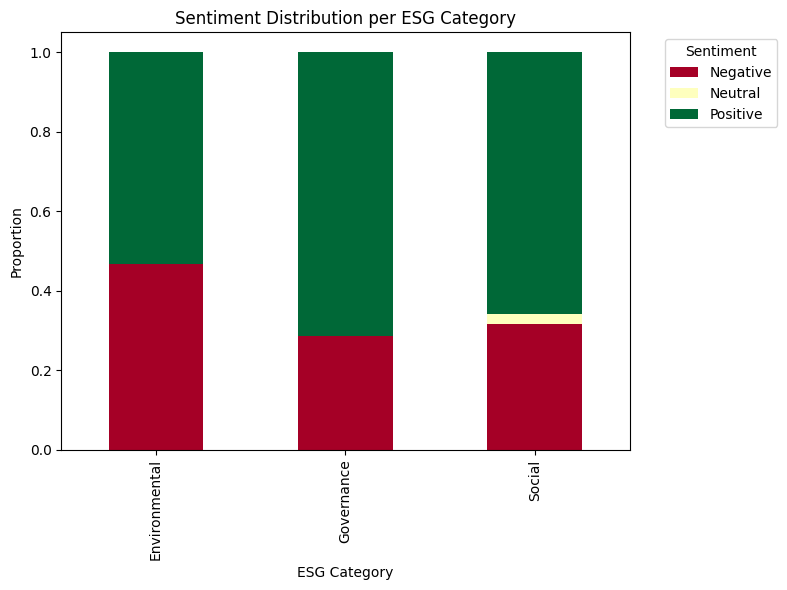

In [ ]:
import seaborn as sns

# Group by ESG label & Sentiment score
sentiment_dist = df.groupby(["predicted_label", "sentiment"]).size().reset_index(name="count")

# Pivot
pivot_df = sentiment_dist.pivot(index="predicted_label", columns="sentiment", values="count").fillna(0)

# Normalize to %
pivot_df_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot
pivot_df_pct.plot(kind="bar", stacked=True, figsize=(8,6), colormap="RdYlGn")
plt.title("Sentiment Distribution per ESG Category")
plt.ylabel("Proportion")
plt.xlabel("ESG Category")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

*Sentiment Distribution per ESG Category Commentary*

1. **Environmental** articles show a more balanced tone, with almost half of them carrying **negative** sentiment, reflecting the often critical nature of environmental reporting (e.g., pollution, emissions, climate concerns).  
2. **Governance** articles are predominantly **positive**, though around **30% are negative**, indicating a mix of coverage between successful corporate governance practices and critical issues.  
3. **Social** articles also lean strongly **positive**, with only a small share of neutral sentiment. This suggests that social-related reporting tends to highlight constructive or progressive developments (e.g., inclusion, community projects).  

*Conclusion*

Overall, the results confirm that while **Environmental** topics are more often reported `negatively` compared to **Governance** and **Social** are portrayed more `positively` in the dataset.

### C6. PCA Visualization of DistilBERT Embeddings

To further analyze the separability of ESG categories, we applied **Principal Component Analysis (PCA)** on the embeddings generated by the fine-tuned DistilBERT model. PCA reduces the dimensionality of the high-dimensional transformer representations into two principal components (PC1, PC2), allowing us to visualize the clustering of articles across the ESG dimensions.  

The resulting scatter plot shows articles projected into 2D space, with each point colored according to its ESG label (Environmental, Social, Governance). This helps evaluate whether the learned embeddings capture meaningful structure between classes.

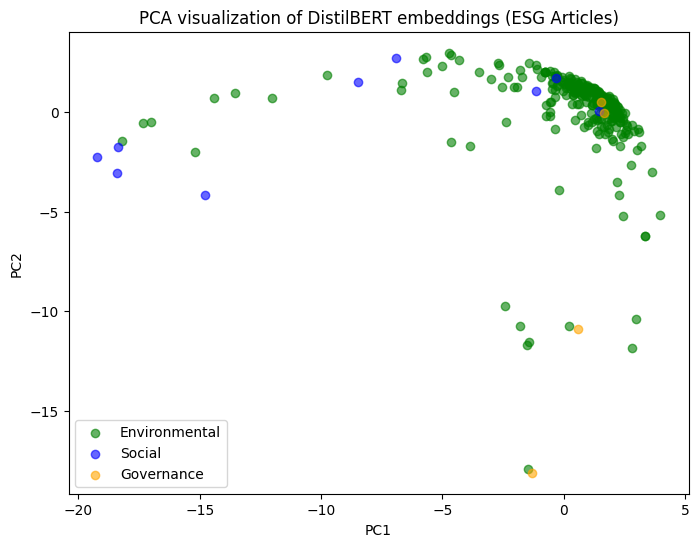

In [ ]:
from sklearn.decomposition import PCA

# Extract embeddings
def get_embeddings(texts, model, tokenizer, batch_size=16, max_length=128):
    model.eval()
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            outputs = model.distilbert(**encodings) 
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  
        all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

# Embeddings for the test set
sample_texts = test_df["text_clean"].tolist()[:300]  
embeddings = get_embeddings(sample_texts, model, tokenizer)

# PCA to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

y_labels = test_df[label_cols].values[:300]  
dominant_labels = np.argmax(y_labels, axis=1)  # E=0, S=1, G=2

colors = ["green", "blue", "orange"]
label_names = ["Environmental", "Social", "Governance"]

plt.figure(figsize=(8,6))
for i, label in enumerate(label_names):
    idxs = dominant_labels == i
    plt.scatter(reduced_embeddings[idxs,0], reduced_embeddings[idxs,1], 
                label=label, alpha=0.6, c=colors[i])

plt.legend()
plt.title("PCA visualization of DistilBERT embeddings (ESG Articles)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

*PCA Visualization Commentary*

PCA was applied to the DistilBERT embeddings to reduce their dimensionality into two components (PC1, PC2).  

- 1. **Environmental articles** form a tighter cluster, showing that the model captures consistent semantic patterns.  
- 2. **Social and Governance articles** appear more scattered, reflecting higher conceptual variability.  

This dispersion explains the lower predictive performance for Social and Governance observed in ROC and PR curves.  

*Conclusion*

Overall, PCA illustrates how DistilBERT embeddings capture similarities and differences across ESG categories, while highlighting the challenges of abstract dimensions such as Social and Governance.  